# Phase Angle Monitoring

## Summary
This notebook shows a proof of concept approach to phase angle monitoring, which can be revealing of important system changes. For some additional context, [this NI4AI blog post](https://blog.ni4ai.org/post/2021-04-25-angle-differencing/) provides an introductory intuition for the physical meaning of voltage phase angles, while [this NASPI report](https://www.naspi.org/sites/default/files/reference_documents/0.pdf) discusses phase angle monitoring applications more deeply. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import btrdb
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds
from library.utils import streams_to_df, describe_streams

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
%load_ext autoreload
%autoreload 2

In [2]:
#Establishing the connecting to the server
db = btrdb.connect(profile='ni4ai')
print(db.info())

{'majorVersion': 5, 'build': '5.12.5', 'proxy': {'proxyEndpoints': []}}


## Getting voltage magnitude streams
Obtain some voltage magnitude streams. 

In [3]:
vmags_streams = db.streams_in_collection('events/switching_A', tags={'name':'Ph1_Vmag'})
print(describe_streams(vmags_streams[:3]))

  Index  Collection                         Name      Units    UUID
-------  ---------------------------------  --------  -------  ------------------------------------
      0  events/switching_A/StationB_Line2  Ph1_Vmag  volts    e2fa9ec2-9b10-438a-be71-5b075ed58bfe
      1  events/switching_A/StationB_Line3  Ph1_Vmag  volts    840daf74-a482-4a3c-824d-50eccf370d45
      2  events/switching_A/StationG_Line4  Ph1_Vmag  volts    c264e611-c901-451d-b64a-2ddf5dcef1c9


In [4]:
start = vmags_streams[0].earliest()[0].time
end = vmags_streams[0].latest()[0].time
magnitudes = streams_to_df(vmags_streams, start=start, end=end, to_datetime=True)
magnitudes.head()

Getting streams:   0%|          | 0/23 [00:00<?, ?it/s]

collection,events/switching_A/StationB_Line2,events/switching_A/StationB_Line3,events/switching_A/StationG_Line4,events/switching_A/StationD_Line2,events/switching_A/StationA_Line4,events/switching_A/StationF_Line1,events/switching_A/StationA_Line5,events/switching_A/StationD_Line3,events/switching_A/StationC_Line1,events/switching_A/StationB_Line1,...,events/switching_A/StationG_Line2,events/switching_A/StationB_Line4,events/switching_A/StationA_Line1,events/switching_A/StationE_Line1,events/switching_A/StationA_Line2,events/switching_A/StationI_Line1,events/switching_A/StationD_Line1,events/switching_A/StationE_Line2,events/switching_A/StationI_Line2,events/switching_A/StationH_Line1
unit,volts,volts,volts,volts,volts,volts,volts,volts,volts,volts,...,volts,volts,volts,volts,volts,volts,volts,volts,volts,volts
name,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,...,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag,Ph1_Vmag
agg,value,value,value,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00.000000000,200825.5469,200825.5469,205673.8906,204653.4063,200670.2344,205194.4375,200670.2344,204653.4063,205672.7500,200825.5469,...,205427.8594,200825.5469,200670.2344,204280.5938,200670.2344,81716.6641,204653.4063,204280.5938,80239.1953,206001.1719
2020-01-01 00:00:00.033332992,200824.0938,200824.0938,205678.5781,204659.6875,200669.9219,205210.6094,200669.9219,204659.6875,205670.5000,200824.0938,...,205423.8125,200824.0938,200669.9219,204274.2656,200669.9219,81718.8359,204659.6875,204274.2656,80233.5156,205996.6563
2020-01-01 00:00:00.066667008,200799.7969,200799.7969,205681.5781,204653.4063,200635.1719,205211.9688,200635.1719,204653.4063,205673.6250,200799.7969,...,205428.0625,200799.7969,200635.1719,204274.2656,200635.1719,81725.0469,204653.4063,204274.2656,80241.4141,205995.4688
2020-01-01 00:00:00.100000000,200795.5000,200795.5000,205681.3438,204640.8281,200641.2344,205206.9063,200641.2344,204640.8281,205675.8750,200795.5000,...,205438.6094,200795.5000,200641.2344,204267.9531,200641.2344,81726.3750,204640.8281,204267.9531,80248.0938,205992.0625
2020-01-01 00:00:00.133332992,200806.5938,200806.5938,205688.5156,204647.1094,200647.2813,205208.0469,200647.2813,204647.1094,205675.8438,200806.5938,...,205446.5000,200806.5938,200647.2813,204267.9531,200647.2813,81735.1328,204647.1094,204267.9531,80253.4766,205987.2969


## Getting voltage angle streams
Obtain the corresponding voltage angle streams. 

In [5]:
vangs_streams = db.streams_in_collection('events/switching_A', tags={'name':'Ph1_Vang'})
print(describe_streams(vangs_streams[:3]))

  Index  Collection                         Name      Units    UUID
-------  ---------------------------------  --------  -------  ------------------------------------
      0  events/switching_A/StationB_Line2  Ph1_Vang  deg      df5c20f6-a938-4c61-b578-480ef662e46e
      1  events/switching_A/StationG_Line4  Ph1_Vang  deg      5405e955-4127-4fe1-a43d-7cf595a8cd13
      2  events/switching_A/StationF_Line1  Ph1_Vang  deg      5e92b048-0a4a-48f2-bdc2-0ccaf5abcc7f


In [6]:
start = vangs_streams[0].earliest()[0].time
end = vangs_streams[0].latest()[0].time
angles = streams_to_df(vangs_streams, start=start, end=end, to_datetime=True)
angles.head()

Getting streams:   0%|          | 0/23 [00:00<?, ?it/s]

collection,events/switching_A/StationB_Line2,events/switching_A/StationG_Line4,events/switching_A/StationF_Line1,events/switching_A/StationA_Line5,events/switching_A/StationA_Line2,events/switching_A/StationE_Line2,events/switching_A/StationD_Line3,events/switching_A/StationB_Line1,events/switching_A/StationG_Line2,events/switching_A/StationA_Line1,...,events/switching_A/StationI_Line1,events/switching_A/StationG_Line1,events/switching_A/StationG_Line3,events/switching_A/StationA_Line3,events/switching_A/StationB_Line3,events/switching_A/StationH_Line1,events/switching_A/StationD_Line2,events/switching_A/StationA_Line4,events/switching_A/StationD_Line1,events/switching_A/StationI_Line2
unit,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,...,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg
name,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,...,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang
agg,value,value,value,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00.000000000,-159.1161,102.6310,-148.2549,-150.5107,-150.5107,-140.7127,-142.2310,-159.1161,-137.2557,-150.5107,...,86.3717,-137.2557,-137.2557,-150.5107,-159.1161,-140.5242,-142.2310,-150.5107,-142.2310,67.0706
2020-01-01 00:00:00.033332992,-158.7711,103.0292,-147.8472,-150.1088,-150.1088,-140.3174,-141.8414,-158.7711,-136.8560,-150.1088,...,86.7668,-136.8560,-136.8560,-150.1088,-158.7711,-140.1241,-141.8414,-150.1088,-141.8414,67.4672
2020-01-01 00:00:00.066667008,-158.4777,103.4278,-147.4375,-149.7061,-149.7061,-139.9220,-141.4518,-158.4777,-136.4556,-149.7061,...,87.1177,-136.4556,-136.4556,-149.7061,-158.4777,-139.7229,-141.4518,-149.7061,-141.4518,67.8298
2020-01-01 00:00:00.100000000,-158.0757,103.8253,-147.0415,-149.3213,-149.3213,-139.5210,-141.0508,-158.0757,-136.0593,-149.3213,...,87.4998,-136.0593,-136.0593,-149.3213,-158.0757,-139.3235,-141.0508,-149.3213,-141.0508,68.2232
2020-01-01 00:00:00.133332992,-157.6505,104.2200,-146.6587,-148.9289,-148.9289,-139.1256,-140.6554,-157.6505,-135.6658,-148.9289,...,87.9239,-135.6658,-135.6658,-148.9289,-157.6505,-138.9281,-140.6554,-148.9289,-140.6554,68.6609


## Visualize the raw (wrapped) angle data
We query some data from the angle streams and plot it. 

In [7]:
angles.columns.get_level_values(level='collection')

Index(['events/switching_A/StationB_Line2',
       'events/switching_A/StationG_Line4',
       'events/switching_A/StationF_Line1',
       'events/switching_A/StationA_Line5',
       'events/switching_A/StationA_Line2',
       'events/switching_A/StationE_Line2',
       'events/switching_A/StationD_Line3',
       'events/switching_A/StationB_Line1',
       'events/switching_A/StationG_Line2',
       'events/switching_A/StationA_Line1',
       'events/switching_A/StationE_Line1',
       'events/switching_A/StationC_Line1',
       'events/switching_A/StationB_Line4',
       'events/switching_A/StationI_Line1',
       'events/switching_A/StationG_Line1',
       'events/switching_A/StationG_Line3',
       'events/switching_A/StationA_Line3',
       'events/switching_A/StationB_Line3',
       'events/switching_A/StationH_Line1',
       'events/switching_A/StationD_Line2',
       'events/switching_A/StationA_Line4',
       'events/switching_A/StationD_Line1',
       'events/switching_A/Stati

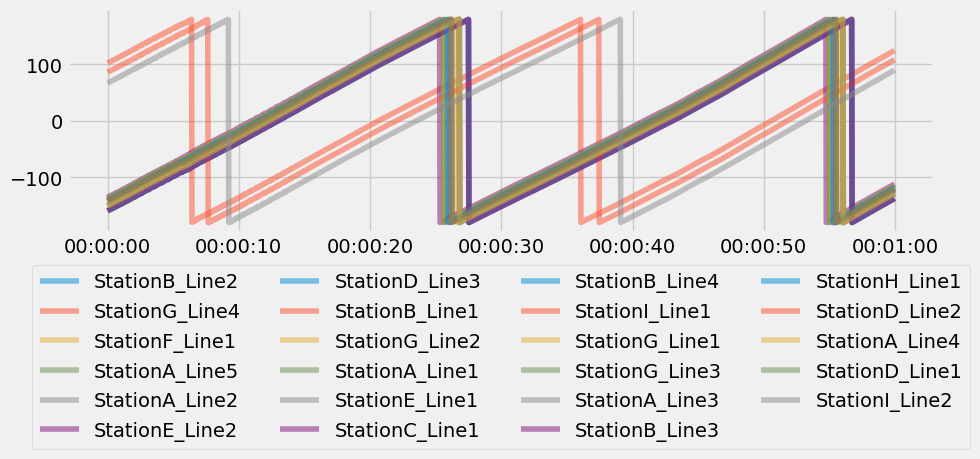

In [8]:
plt.figure(figsize=(10,5))
plt.plot(angles, alpha=0.5)
plt.legend([c.split('/')[-1] for c in angles.columns.get_level_values(level='collection')], 
           loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=4)
plt.tight_layout()
plt.show()

### Observations

We see the phase angles follow a sawtooth pattern. This is because they're reported to be between -180 and 180 degrees. It's important to note that the discontinuity is not a meaningful transition in the data, as phase angles of 0 degrees and 360 degrees are mathematically the same.

## Unwrapping phase angles by differencing

Here, we'll "unwrap" the phase angles to remove the discontinuity, by taking angle differences. Only *relative* angles (i.e. angle differences) have physical meaning. Therefore, we will choose a reference point in the system (here `StationB_Line2`) which defines a $0^o$ angle, and all other phase angles will be reported in reference to it as differences.

In [9]:
def ungle_unwrapping(angles, measurement='deg'):
    """
    unwrapped angles with each column contains angle data for a single time serie.
    """    
    if measurement == 'deg':
        unwrapped_angles = np.unwrap(angles, period=360, axis=0)
    elif measurement == 'rad':
        unwrapped_angles = np.unwrap(angles, axis=0)
    else:
        raise ValueError('Measurement has to either be deg or rad.')
        
    
    if isinstance(angles, pd.DataFrame):
        return pd.DataFrame(unwrapped_angles, 
                            index=angles.index, 
                            columns=angles.columns)
    else:
        return unwrapped_angles

In [16]:
# unwrapped angles
unwrapped_angles = ungle_unwrapping(angles, measurement='deg')

# use collection 'StationB_Line2' as the reference angle
ref_angle = unwrapped_angles.iloc[:,0]
print(f'Reference angle stream name : {ref_angle.name[0]}')

# subtract all the other angles by the reference angles 
relative_angle_diff = unwrapped_angles.subtract(ref_angle, axis=0)
# remove the column of reference angle from the dataframe
relative_angle_diff = relative_angle_diff.drop(relative_angle_diff.columns[0], axis = 1) 
relative_angle_diff.head()

Reference angle stream name : events/switching_A/StationB_Line2


collection,events/switching_A/StationG_Line4,events/switching_A/StationF_Line1,events/switching_A/StationA_Line5,events/switching_A/StationA_Line2,events/switching_A/StationE_Line2,events/switching_A/StationD_Line3,events/switching_A/StationB_Line1,events/switching_A/StationG_Line2,events/switching_A/StationA_Line1,events/switching_A/StationE_Line1,...,events/switching_A/StationI_Line1,events/switching_A/StationG_Line1,events/switching_A/StationG_Line3,events/switching_A/StationA_Line3,events/switching_A/StationB_Line3,events/switching_A/StationH_Line1,events/switching_A/StationD_Line2,events/switching_A/StationA_Line4,events/switching_A/StationD_Line1,events/switching_A/StationI_Line2
unit,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,...,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg
name,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,...,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang,Ph1_Vang
agg,value,value,value,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00.000000000,261.7471,10.8612,8.6054,8.6054,18.4034,16.8851,0.0,21.8604,8.6054,18.4034,...,245.4878,21.8604,21.8604,8.6054,0.0,18.5919,16.8851,8.6054,16.8851,226.1867
2020-01-01 00:00:00.033332992,261.8003,10.9239,8.6623,8.6623,18.4537,16.9297,0.0,21.9151,8.6623,18.4537,...,245.5379,21.9151,21.9151,8.6623,0.0,18.6470,16.9297,8.6623,16.9297,226.2383
2020-01-01 00:00:00.066667008,261.9055,11.0402,8.7716,8.7716,18.5557,17.0259,0.0,22.0221,8.7716,18.5557,...,245.5954,22.0221,22.0221,8.7716,0.0,18.7548,17.0259,8.7716,17.0259,226.3075
2020-01-01 00:00:00.100000000,261.9010,11.0342,8.7544,8.7544,18.5547,17.0249,0.0,22.0164,8.7544,18.5547,...,245.5755,22.0164,22.0164,8.7544,0.0,18.7522,17.0249,8.7544,17.0249,226.2989
2020-01-01 00:00:00.133332992,261.8705,10.9918,8.7216,8.7216,18.5249,16.9951,0.0,21.9847,8.7216,18.5249,...,245.5744,21.9847,21.9847,8.7216,0.0,18.7224,16.9951,8.7216,16.9951,226.3114


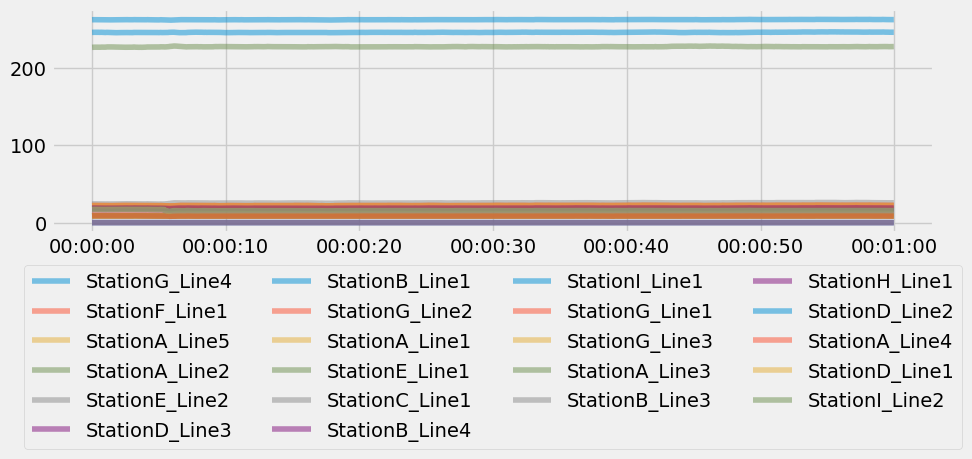

In [11]:
plt.figure(figsize=(10,5))
plt.plot(relative_angle_diff, alpha=0.5)
plt.legend([c.split('/')[-1] for c in relative_angle_diff.columns.get_level_values(level='collection')], 
           loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=4)
plt.tight_layout()
plt.show()

In [12]:
print(f'Streams with relative angle differences greater than 200:\n')

print(*list(relative_angle_diff.columns[relative_angle_diff.mean()>200].get_level_values(0)), sep='\n')

Streams with relative angle differences greater than 200:

events/switching_A/StationG_Line4
events/switching_A/StationI_Line1
events/switching_A/StationI_Line2


### Observations

Phase angle differences no longer exhibit the same discontinuity as before. We note that three of the measurement nodes have much larger phase angle differences (relative to the reference) than other measurement sites. This difference suggests that these sites are electrically distant from the others, possibly on a different phase. 

Let's look at the distributions of these phase angle difference time series. 

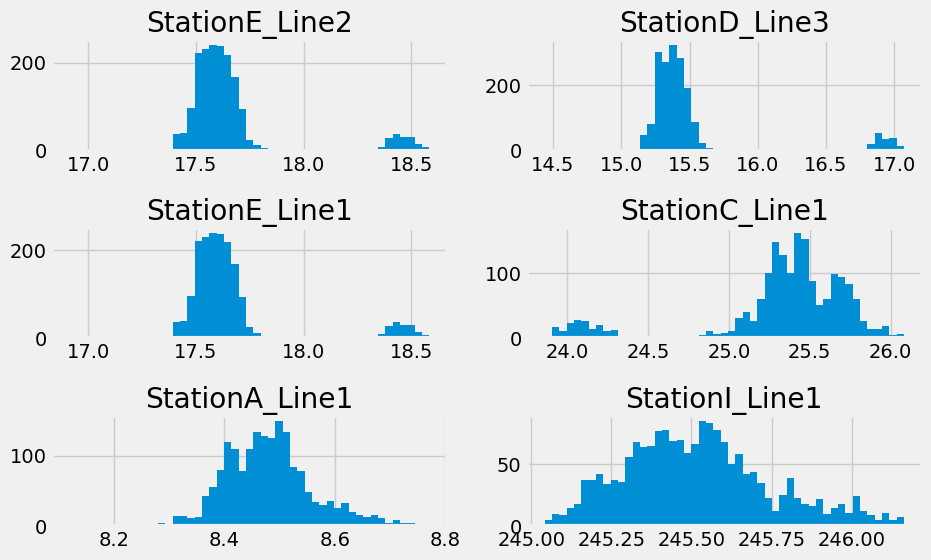

In [13]:
stations = ['StationE_Line2','StationD_Line3','StationE_Line1',
            'StationC_Line1','StationA_Line1','StationI_Line1']
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,6))

for i, ax in enumerate(axs.flatten()):
    
    station = stations[i]
    data = relative_angle_diff.xs(f'events/switching_A/{station}', level='collection', axis=1)
    bins = np.linspace(data.min().iloc[0], data.max().iloc[0], 50)
    ax.hist(data.values, bins=bins)
    ax.set_title(station)
    
fig.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

### Observations

The histogram of phase angles at each measurement site clearly shows that certain sites follow a bimodal distribution, while others do not. This would suggest that phase angle differences in some parts of the network are affected by the switching event, while other nodes are unaffected.

# Phase angle clustering

Here, we'll use gaussian mixture models to cluster phase angle measurements at each site into one of two clusters. We'll also check for time-dependence to confirm the hypothesis that the cluster conforms to "before" and "after" the switching event.

In [14]:
from sklearn import mixture
from scipy import stats
import seaborn as sns

def fit_gmm(data):
    X = np.array(data).reshape((len(data),1))
    return mixture.GaussianMixture(n_components=2).fit(X)
    
def get_pdfs(gmm, bins=bins):
    pdfs = []
    for i in range(gmm.n_components):
        mean = gmm.means_[i,0]
        std = np.sqrt(gmm.covariances_[i,0,0])
        wt = gmm.weights_[i,]
        
        rv = stats.norm(mean, std)
        pdfs.append(wt*rv.pdf(bins))
    return pdfs

def get_clusters(data, gmm):
    X = np.array(data).reshape((len(data),1))
    return gmm.predict(X), gmm.predict_proba(X)

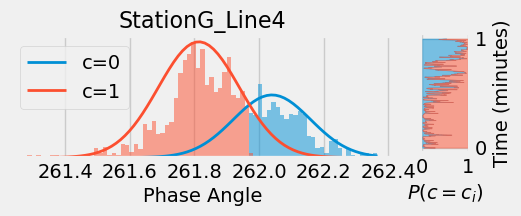

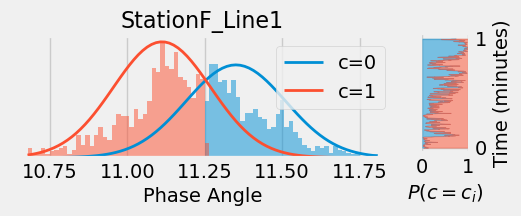

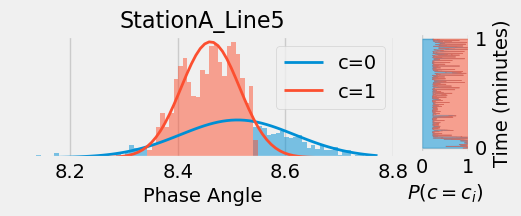

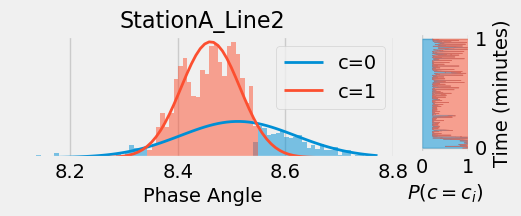

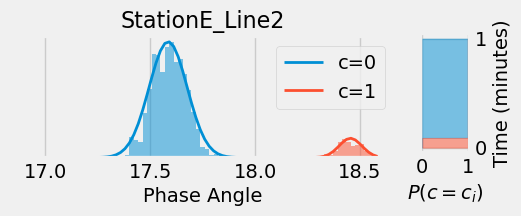

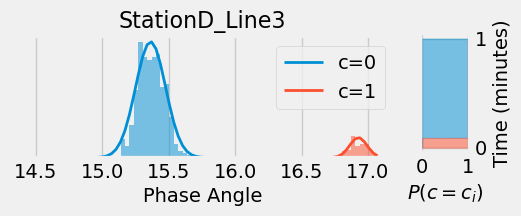

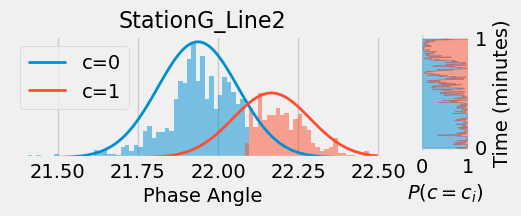

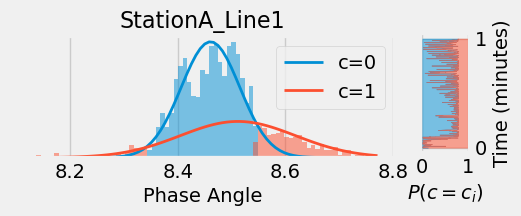

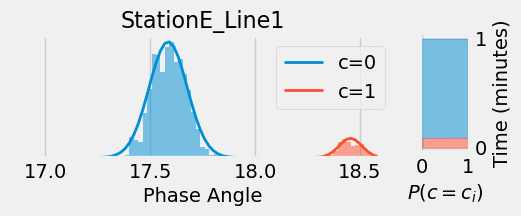

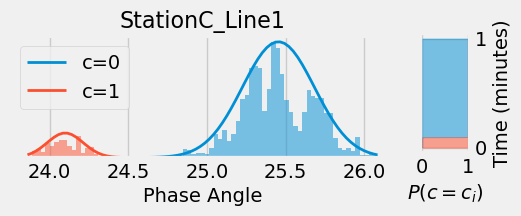

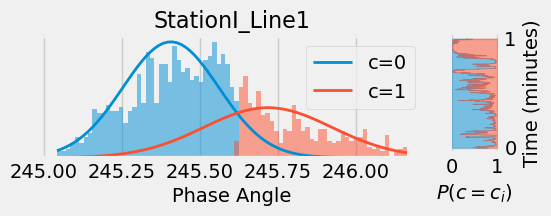

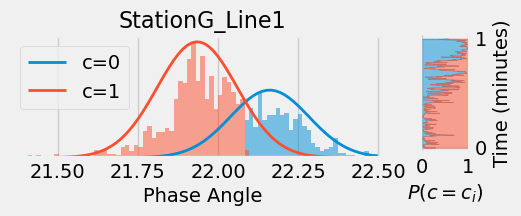

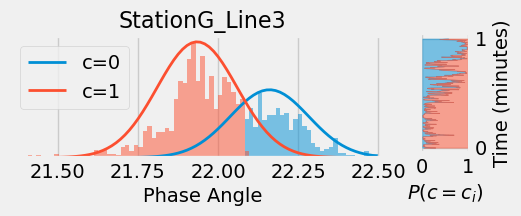

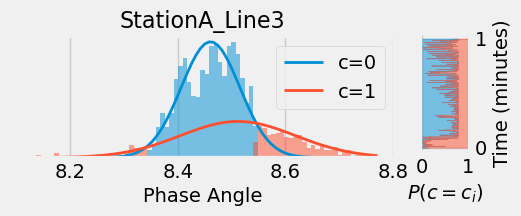

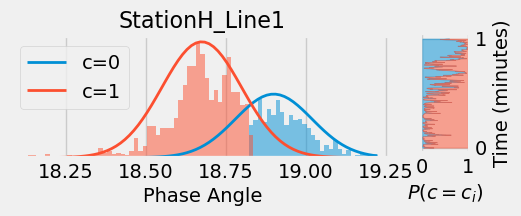

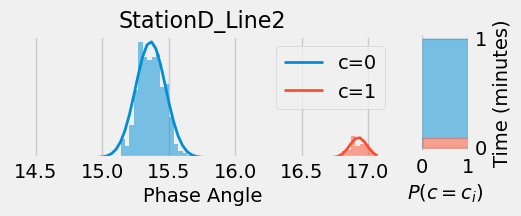

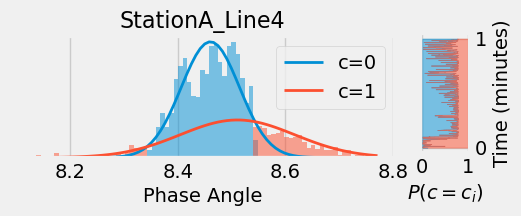

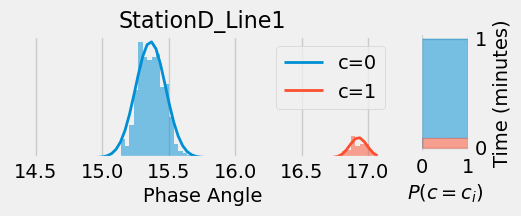

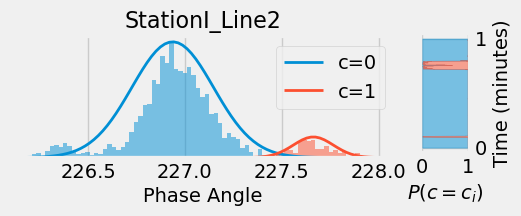

In [15]:
transition_points = []
for s in relative_angle_diff.keys():
    
    data = relative_angle_diff[s]
    if sum(data) == 0:
        continue
        
    gmm = fit_gmm(data)
    bins = np.linspace(min(data), max(data), 80)
    pdfs = get_pdfs(gmm, bins=bins)
    clusters, probs = get_clusters(data, gmm)
    
    colors = sns.color_palette()
    fig, ax = plt.subplots(figsize=(5,1.5))
    fig.subplots_adjust(right=0.85)
    ax.set_title(s[0].split('/')[-1], fontsize=16)
    ax.set_xlabel('Phase Angle', fontsize=14)

    ax2 = ax.twinx()
    for i in range(gmm.n_components):
        ax.hist(data[clusters==i], bins=bins, color=colors[i], alpha=0.5)
        ax2.plot(bins, pdfs[i], lw=2, color=colors[i], label='c=%i'%(i))
    ax2.legend()
        
    ax.set_yticks([])
    
    ax2.set_ylim((0, ax2.get_ylim()[1]))
    ax2.set_yticks([])
    
    
    ax = fig.add_subplot(111)
    ax.set_position([0.9,0.1,0.1,0.8])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(r'$P(c=c_i)$', fontsize=14)
    
    _ax = ax.twinx()
    _ax.set_position([0.9,0.1,0.1,0.8])
    
    for i in range(gmm.n_components):
        if i == 0:
            _ax.fill_betweenx(data.index, np.zeros(data.shape), probs[:,i],
                          color=colors[i], alpha=0.5, label='c=0')
        elif i == 1:
            _ax.fill_betweenx(data.index, 1-probs[:,i], np.ones(data.shape),
                          color=colors[i], alpha=0.5, label='c=1')
            
            
    _ax.set_yticks([data.index.min(), data.index.max()])
    _ax.set_yticklabels([0,1])
    _ax.set_xticks([0,1])
    low = _ax.get_ylim()[0]
    _ax.set_ylabel('Time (minutes)', fontsize=14)
    plt.show()

### Observations

At some of the stations, we see phase angles clearly separate into one of two clusters. Furthermore, we note that there is clear time structure to the clustering. The graph on the right shows probabilistic cluster assignments (x-axis) at each time step in the data (y-axis). For many of the nodes, there is very obviously a transition point where the phase angle transitions, first centering around one value and then centering around another.

At other nodes, there is much less separation between nodes and it is unclear whether or not there is any kind of time structure to cluster assignments.